In [ ]:
!pip install diffusers transformers
!pip install datasets
!pip install torchvision
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 99.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler, UNet2DModel
from transformers import BertModel, BertTokenizer
from diffusers.optimization import get_cosine_schedule_with_warmup
import torch
import torchvision
import accelerate
from accelerate import Accelerator
from torchvision import transforms, datasets
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(128, 128)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

In [ ]:
data = datasets.Food101(root="/kaggle/working",
                        split='train',
                        transform=data_transform,
                        download=True)

100%|██████████| 4996278331/4996278331 [04:45<00:00, 17482197.68it/s]


Extracting /kaggle/working/food-101.tar.gz to /kaggle/working


In [18]:
data.classes

['apple pie',
 'baby back ribs',
 'baklava',
 'beef carpaccio',
 'beef tartare',
 'beet salad',
 'beignets',
 'bibimbap',
 'bread pudding',
 'breakfast burrito',
 'bruschetta',
 'caesar salad',
 'cannoli',
 'caprese salad',
 'carrot cake',
 'ceviche',
 'cheese plate',
 'cheesecake',
 'chicken curry',
 'chicken quesadilla',
 'chicken wings',
 'chocolate cake',
 'chocolate mousse',
 'churros',
 'clam chowder',
 'club sandwich',
 'crab cakes',
 'creme brulee',
 'croque madame',
 'cup cakes',
 'deviled eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs benedict',
 'escargots',
 'falafel',
 'filet mignon',
 'fish and chips',
 'foie gras',
 'french fries',
 'french onion soup',
 'french toast',
 'fried calamari',
 'fried rice',
 'frozen yogurt',
 'garlic bread',
 'gnocchi',
 'greek salad',
 'grilled cheese sandwich',
 'grilled salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot and sour soup',
 'hot dog',
 'huevos rancheros',
 'hummus',
 'ice cream',
 'lasagna',
 'lobster bisque',
 'lobster

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model = UNet2DConditionModel(sample_size=(16,16), block_out_channels=(256,512,1024,1024), encoder_hid_dim=768).to(torch.float32).to(device)
scheduler = DDIMScheduler().from_pretrained('CompVis/ldm-text2im-large-256', subfolder='scheduler')
vqvae = AutoencoderKL().from_pretrained('CompVis/ldm-text2im-large-256', subfolder='vqvae', torch_dtype=torch.float32).to(device)
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
text_encoder = BertModel.from_pretrained("google-bert/bert-base-uncased").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


scheduler/scheduler_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

The config attributes {'timestep_values': None} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


vqvae/config.json:   0%|          | 0.00/522 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def get_text_embeds(prompt):
  # Tokenize text and get embeddings
  text_input = tokenizer(
      prompt, padding='max_length', max_length=77,
      truncation=True, return_tensors='pt')
  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0].to(torch.float32)
  return text_embeddings

In [ ]:
data.classes = [classes.replace('_', ' ') for classes in data.classes]

  0%|          | 0/592 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Finished epoch 0. Average of the last 100 loss values: 0.548922


  0%|          | 0/592 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.528467


  0%|          | 0/592 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.521189


  0%|          | 0/592 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.517052


  0%|          | 0/592 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.507810


  0%|          | 0/592 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.505679


  0%|          | 0/592 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.502499


  0%|          | 0/592 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.502748


  0%|          | 0/592 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 100 loss values: 0.501322


  0%|          | 0/592 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 100 loss values: 0.496007
[1.172758936882019, 1.2115072011947632, 0.901833713054657, 0.9319851398468018, 0.7533934116363525, 0.7477771043777466, 0.7730953693389893, 0.7127841711044312, 0.7155554294586182, 0.6847817897796631, 0.6918017864227295, 0.6647565364837646, 0.668717622756958, 0.6656010150909424, 0.6575627326965332, 0.6127325296401978, 0.6500244140625, 0.6656014919281006, 0.6681870222091675, 0.6512337327003479, 0.702472448348999, 0.6607058644294739, 0.672386646270752, 0.6511356830596924, 0.6791422963142395, 0.5808629989624023, 0.655154824256897, 0.6733196377754211, 0.6103484034538269, 0.6197559833526611, 0.617912769317627, 0.5797015428543091, 0.6027684211730957, 0.595104455947876, 0.6371913552284241, 0.6222949028015137, 0.6225571632385254, 0.6448684930801392, 0.6102908849716187, 0.6217828989028931, 0.6539558172225952, 0.616715669631958, 0.5989322662353516, 0.6303181052207947, 0.6289925575256348, 0.5856767892837524, 0.5798946022987366, 0.59214

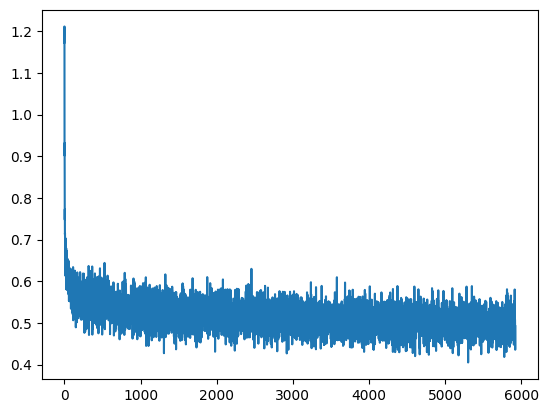

In [ ]:
# import math
train_dataloader = DataLoader(data, batch_size=256, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 -1 # Data on the GPU (mapped to (-1, 1))
        x = x.to(torch.float32)
        with torch.no_grad():
            x = vqvae.encode(x).latent_dist.sample()

        noise = torch.randn_like(x)
        y = [data.classes[y_value] for y_value in y]
        y_embeddings = get_text_embeds(y)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = scheduler.add_noise(x, noise, timesteps).to(torch.float32)
        # Get the model prediction
        pred = model(noisy_x, timesteps, y_embeddings).sample # Note that we pass in the labels y
          # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise
          # Backprop and update the params:
        loss.backward()
        opt.step()
        opt.zero_grad()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
print(losses)
plt.plot(losses)

In [ ]:
latent = torch.randn((1,4,16,16)).to(device)
prompt = get_text_embeds(['pizza']).to(device)

In [ ]:
eta = 0.01
scheduler.set_timesteps(1000)
with torch.no_grad():
    for t in scheduler.timesteps:
        noise_pred = model(latent, t, prompt).sample
        latent = scheduler.step(noise_pred, t, latent, eta).prev_sample

In [ ]:
with torch.no_grad():
    decoded_image = vqvae.decode(latent).sample.detach().to(torch.float32)
decoded_image = (decoded_image / 2 + 0.5).clamp(0, 1)
decoded_image = decoded_image.cpu().permute(0, 2, 3, 1).numpy()

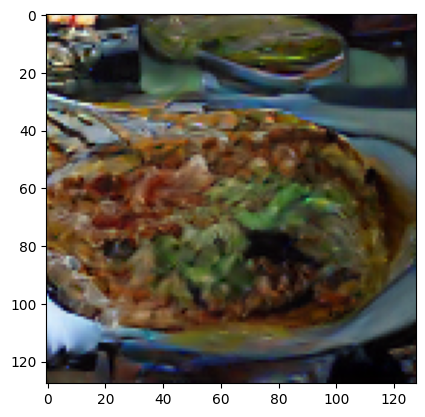

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(decoded_image[0])